In [ ]:
import torch
from torch.utils.data import Dataset
from glob import glob
import os
import datetime
import gzip
import xarray as xr


class JPLDGIMDataset(Dataset):
    def __init__(self, data_dir, normalize=False):
        print('JPL GIM Dataset')
        self.data_dir = data_dir
        self.normalize = normalize
        dates_avialable = self.find_date_range(data_dir)
        if dates_avialable is None:
            raise ValueError("No data found in the specified directory.")
        self.date_start, self.date_end = dates_avialable
        self.num_days = (self.date_end - self.date_start).days + 1
        cadence = 15 # minutes
        self.num_samples = int(self.num_days * (24 * 60 / cadence))
        print('Number of days in dataset   : {:,}'.format(self.num_days))
        print('Number of samples in dataset: {:,}'.format(self.num_samples))
        # size on disk
        size_on_disk = sum(os.path.getsize(f) for f in glob(f"{data_dir}/*/*.nc.gz"))
        print('Size on disk                : {:.2f} GB'.format(size_on_disk / (1024 ** 3)))

    @staticmethod
    def find_date_range(directory):
        # print("Checking date range of data in directory: {}".format(directory))
        days = sorted(glob(f"{directory}/*/*.nc.gz"))
        if len(days) == 0:
            return None

        # print(directory)
        # print(days[0])
        # print(days[-1])
        # example output:
        # /disk2-ssd-8tb/data/2025-hl-ionosphere/gim_jpld_20100513-20240731/2010/jpld1330.10i.nc.gz
        # /disk2-ssd-8tb/data/2025-hl-ionosphere/gim_jpld_20100513-20240731/2023/jpld1470.23i.nc.gz

        days = [d.replace(directory, '') for d in days]
        date_start = datetime.datetime.strptime(days[0].split('.')[0], "/%Y/jpld%j0")
        date_end = datetime.datetime.strptime(days[-1].split('.')[0], "/%Y/jpld%j0")

        print("Directory  : {}".format(directory))
        print("Start date : {}".format(date_start.strftime('%Y-%m-%d')))
        print("End date   : {}".format(date_end.strftime('%Y-%m-%d')))

        return date_start, date_end

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        samples_per_day = 24 * 60 // 15  # 15-minute cadence
        if isinstance(index, datetime.datetime):
            date = index
        elif isinstance(index, int):
            if index < 0 or index >= self.num_samples:
                raise IndexError("Index out of range for the dataset.")
            days = index // samples_per_day
            minutes = (index % samples_per_day) * 15
            date = self.date_start + datetime.timedelta(days=days, minutes=minutes)
        else:
            raise TypeError("Index must be an integer or a datetime object.")

        file_name = f"jpld{date:%j}0.{date:%y}i.nc.gz"
        file_path = os.path.join(self.data_dir, f"{date:%Y}", file_name)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        with gzip.open(file_path, 'rb') as f:
            ds = xr.open_dataset(f, engine='h5netcdf')
            
            # Assuming 'tecmap' is the variable of interest
            data = ds['tecmap'].values
            # data_tensor shape torch.Size([96, 180, 360]) where 96 is nepochs, 180 is nlats, and 360 is nlons
            data_tensor = torch.tensor(data, dtype=torch.float32)

            # get the correct time
            time_index = index % samples_per_day

            data = data_tensor[time_index, :, :]  # Select the slice for the specific time index

        return data

dataset = JPLDGIMDataset(data_dir='/disk2-ssd-8tb/data/2025-hl-ionosphere/gim_jpld_20100513-20240731')


JPL GIM Dataset
Directory  : /disk2-ssd-8tb/data/2025-hl-ionosphere/gim_jpld_20100513-20240731
Start date : 2010-05-13
End date   : 2024-07-31
Number of days in dataset   : 5,194
Number of samples in dataset: 498,624
Size on disk                : 18.89 GB


torch.Size([180, 360])


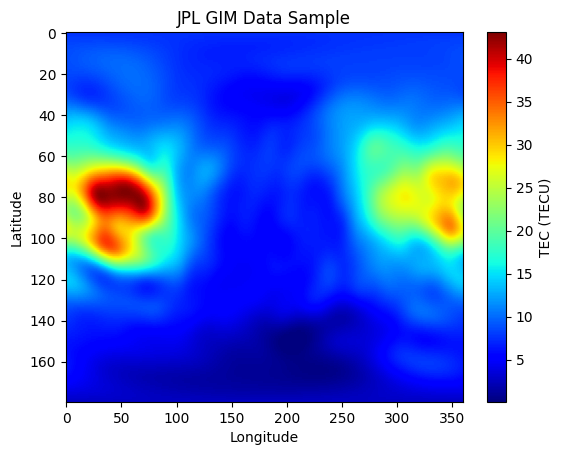

In [74]:
import matplotlib.pyplot as plt

data = dataset[5]
print(data.shape)  # Should print torch.Size([180, 360])

plt.imshow(data.numpy(), cmap='jet', aspect='auto')
plt.colorbar(label='TEC (TECU)')
plt.title('JPL GIM Data Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()